In [1]:
# an implementation of Self-Compressing Neural Networks
# https://arxiv.org/pdf/2301.13142
import os
#os.environ["DEBUG"] = '2'
#os.environ["JITBEAM"] = '3'   # make tinygrad fast, first run is slow but then it's fast
from tinygrad.nn.datasets import mnist
X_train, Y_train, X_test, Y_test = mnist()

In [2]:
from tinygrad import Tensor, nn, TinyJit, dtypes
from tinygrad.helpers import prod
import math, functools

class QConv2d:
  def __init__(self, in_channels, out_channels, kernel_size):
    self.kernel_size = (kernel_size, kernel_size) if isinstance(kernel_size, int) else tuple(kernel_size)
    scale = 1 / math.sqrt(in_channels * prod(self.kernel_size))
    self.weight = Tensor.uniform(out_channels, in_channels, *self.kernel_size, low=-scale, high=scale)
    self.e = Tensor.full((out_channels, 1, 1, 1), -8.)
    self.b = Tensor.full((out_channels, 1, 1, 1), 2.)  # start with 2 bits per weight

  def qbits(self):
    return self.b.sum() * prod(self.weight.shape[1:])

  def qweight(self):
    return Tensor.minimum(Tensor.maximum(2**-self.e * self.weight, -2**(self.b.relu()-1)), 2**(self.b.relu()-1) - 1)
  
  def __call__(self, x:Tensor):
    qw = self.qweight()
    w = (qw.round() - qw).detach() + qw  # straight through estimator
    return x.conv2d(2**self.e * w)

class Model:
  def __init__(self):
    self.layers: List[Callable[[Tensor], Tensor]] = [ 
      QConv2d(1, 32, 5), Tensor.relu,
      QConv2d(32, 32, 5), Tensor.relu,
      nn.BatchNorm(32, affine=False, track_running_stats=False),
      Tensor.max_pool2d,
      QConv2d(32, 64, 3), Tensor.relu,
      QConv2d(64, 64, 3), Tensor.relu,
      nn.BatchNorm(64, affine=False, track_running_stats=False), 
      Tensor.max_pool2d,
      # TODO: do we really need this reshape?
      lambda x: x.flatten(1).reshape(-1, 576, 1, 1),
      QConv2d(576, 10, 1), lambda x: x.flatten(1)]

  def __call__(self, x:Tensor) -> Tensor: return x.sequential(self.layers)

In [3]:
model = Model()
opt = nn.optim.Adam(nn.state.get_parameters(model))
test_accs, bytes_used = [], []
weight_count = sum(t.numel() for t in opt.params)
len(opt.params), weight_count

(15, 87860)

In [4]:
@TinyJit
def train_step() -> Tensor:
  with Tensor.train():
    opt.zero_grad()
    samples = Tensor.randint(512, high=X_train.shape[0])
    loss = model(X_train[samples]).sparse_categorical_crossentropy(Y_train[samples])
    Q = functools.reduce(lambda x,y: x+y, [l.qbits() for l in model.layers if isinstance(l, QConv2d)]) / weight_count
    loss = loss + 0.05*Q   # hyperparameter determines compression vs accuracy
    loss.backward()
    opt.step()
  return loss, Q

@TinyJit
def get_test_acc() -> Tensor: return (model(X_test).argmax(axis=1) == Y_test).mean()*100

Tensor.training = True
from tqdm import trange
test_acc = float('nan')
for i in (t:=trange(5000)):
  loss, Q = train_step()
  bytes = Q.item()/8*weight_count
  if i%10 == 9:
    test_acc = get_test_acc().item()
    test_accs.append(test_acc)
    bytes_used.append(bytes)
  t.set_description(f"loss: {loss.item():6.2f}  bytes: {bytes:.1f}  acc: {test_acc:5.2f}%")

loss:   0.16  bytes: 22747.1  acc: 97.57%: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:08<00:00, 38.94it/s]


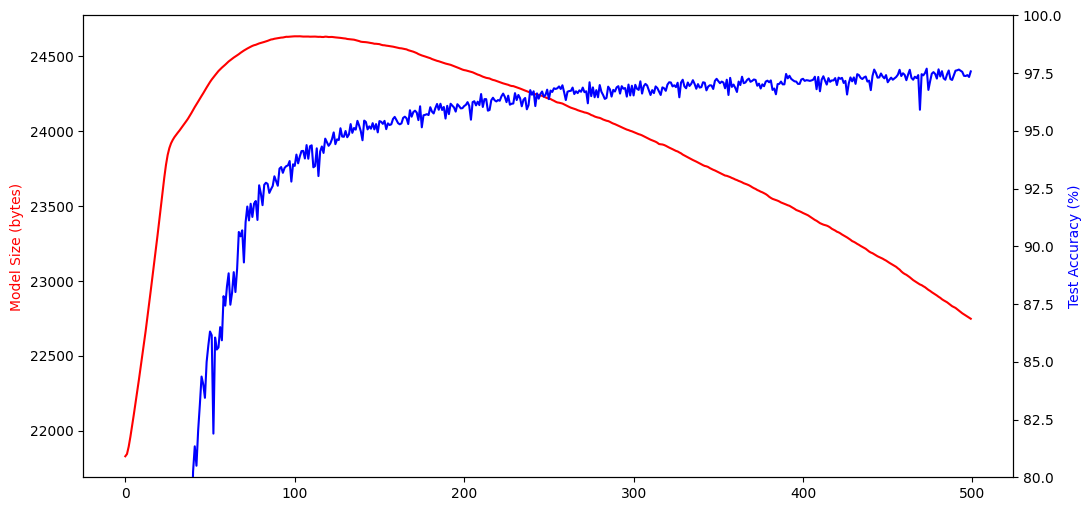

In [12]:
from matplotlib import pyplot as plt
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_ylabel("Model Size (bytes)")
ax1.yaxis.label.set_color("red")
ax1.plot(bytes_used, color="red")
ax2 = ax1.twinx()
ax2.plot(test_accs, color="blue")
plt.ylim(80, 100)
ax2.set_ylabel("Test Accuracy (%)")
ax2.yaxis.label.set_color("blue")

In [6]:
import numpy as np
np.set_printoptions(suppress=True, linewidth=200)
for k,v in nn.state.get_state_dict(model).items():
  if k.endswith(".b") or k.endswith(".e"):
    print(k, v.shape, v.numpy().flatten()[0:10])
from collections import Counter
for i,l in enumerate(model.layers):
  if isinstance(l, QConv2d):
    print(f"QConv2d {i} weights", [x[1] for x in sorted(Counter(l.qweight().round().numpy().flatten().tolist()).items())])

layers.0.e (32, 1, 1, 1) [-7.80484   -7.5967455 -7.1167555 -7.0047345 -7.1812706 -8.2680025 -7.491517  -8.011836  -7.402195  -7.5725775]
layers.0.b (32, 1, 1, 1) [2.3636365 2.8070562 2.3073876 2.994184  1.68772   2.369595  2.6370993 1.4382905 3.1133337 2.6203394]
layers.2.e (32, 1, 1, 1) [-7.743885  -8.603085  -9.351423  -7.377988  -8.463519  -8.123641  -7.8891907 -8.458355  -8.284161  -8.167926 ]
layers.2.b (32, 1, 1, 1) [2.3221762  1.3043208  1.7399076  2.2834206  2.1671305  1.5417873  2.2361937  2.3326344  0.97049546 2.1076138 ]
layers.6.e (64, 1, 1, 1) [-7.1980143 -8.169997  -8.095202  -7.3929152 -8.098155  -6.9264674 -7.340473  -8.450187  -7.882276  -7.692756 ]
layers.6.b (64, 1, 1, 1) [ 2.8093574   2.3216064   0.72211903  2.0784206   1.397682    2.3123138   2.322236   -0.05346395  1.7274115   2.2971506 ]
layers.8.e (64, 1, 1, 1) [-7.3415284 -7.325212  -7.0600514 -6.9855213 -7.4771376 -6.9759045 -7.1096354 -7.0117345 -7.2457666 -7.188055 ]
layers.8.b (64, 1, 1, 1) [2.3847973 2.323